/Users/Chiara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Chiara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:52: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Chiara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:68: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/Chiara/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:85: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


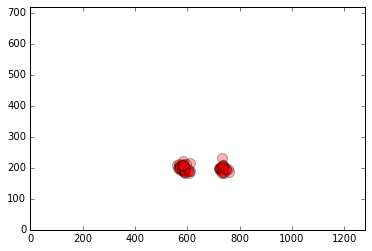

In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

#Parameters setting:
sc_fct = 1.1            #scaling factor
min_neigh = 10          #minimum number of neighbours to identify an area as the specific object
min_size_f = (30,30)    #smallest face dimensions accepted
min_size_e = (10,10)    #smallest eye dimension accepted  
mindist_c=20            #minimum distance between circles' centers
param1_c=30             #specific parameter of the Hough Gradient detection method 
param2_c=10             #specific parameter of the Hough Gradient detection method
minr_c=10               #minimum circle radius accepted
maxr_c=40               #maximum circle radius accepted
dp_c=1                  #accumulator resolution factor

#Loading the cascade classifier files
faceCascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")
eyeCascade=cv2.CascadeClassifier("haarcascade_eye.xml")

#Capturing the video from the webcam and opening a window to display it
video_capture = cv2.VideoCapture(0)
cv2.namedWindow("EasYE TRACKING")

#Saving the window dimensions
x_dim = video_capture.get(3)
y_dim = video_capture.get(4)


while True:
    #Capturing frames from the video
    ret, frame = video_capture.read()
    
    #Converting the image from colour to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    #Using the cascade clsiifier to identify faces in the video
    faces = faceCascade.detectMultiScale(       
        gray,
        scaleFactor=sc_fct,
        minNeighbors=min_neigh,
        minSize=min_size_f
        )
    #detectMultiscale function returns a list of rectangles described by the upper left vertex and the two dimension
    
    #Drawing rectangles recognised by the detectMultiscale function
    for (x, y, w, h) in faces:
        cv2.rectangle(frame,(x, y), (x+w, y+h), (0, 255, 0), 2)
        #Defining new regions of interest
        roi_gray=gray[y:y+h/2,x:x+w]
        roi_color=frame[y:y+h/2,x:x+w]
        
        #Using the cascade classifier to identify eyes within the new ROI just defined
        eyes= eyeCascade.detectMultiScale(         
        roi_gray,
        scaleFactor=sc_fct,
        minNeighbors=min_neigh,
        minSize=min_size_e
    )


        #Drawing rectangles returned by the detectMultiscale function
        for (ex, ey, ew, eh) in eyes:
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), (255, 191, 0), 2)
            
            #Defining new regions of interest   
            roi_gray2=roi_gray[ey+(eh/4):ey+eh,ex:ex+ew]
            roi_color2=roi_color[ey:ey+eh,ex:ex+ew]
            
            #Defining threshold values for image filtering (the value corresponds to a grey level)
            lower = 0
            upper = 70
            
            #Applying inRange funtction to pull out from the input image only the pixels that are included in this specific gray range 
            mask = cv2.inRange(roi_gray2, lower, upper)
            #The output is an image where the elements, which are in the range, are shown in white, while everything else il black.  
            
            #Applying HoughCircles function to identify iris and pupil in the filtered image (HOUGH_GRADIENT is the method used)
            circles = cv2.HoughCircles(mask,cv2.HOUGH_GRADIENT,dp=dp_c,minDist=mindist_c,
                    param1=param1_c,param2=param2_c,minRadius=minr_c,maxRadius=maxr_c)
            #The function returns a list of circles described by the centre coordinates and the radius
            
            #Checking validity of the detected objects
            if(circles==None):
                continue
            else:
            #Coverting floats to integers to make values usable by the circle function
                circles = np.uint16(np.around(circles[0,:]))
            
            #Drawing identified circles in the video
                for (x_c,y_c,r) in circles:
                    cv2.circle(roi_color2,(x_c,y_c+int(eh/4)),r,(0,255,0),2)
                    cv2.circle(roi_color2,(x_c,y_c+int(eh/4)),2,(0,0,255),3)
                    
                    #Plotting a scatterplot with the eyes pupils' position through time
                    plt.scatter(x+ex+x_c,y+ey+y_c+int(eh/4), s=100, c='r',alpha=0.3)
                    plt.axis([0,x_dim,0,y_dim])
                    plt.draw()
                
                #Showing the filtered image and the webcam video
                cv2.imshow('mask',mask)
                cv2.imshow('EasEY TRACKING', frame)
    #Breaking the while cicle when 'return' is pressed
    if cv2.waitKey(1)==27:
        break
#Closing al windows and turning webcams off
video_capture.release()
cv2.destroyAllWindows()
              